# Multi-Resident Tracking Performance Metrics

The goal of multi-resident tracking is two folds: 1) associating sensor events activated by the same resident with an identified track; 2) accurately estimating the number of active residents in the smart home.
In this section, we present and discuss a few performance metrics in order to evaluate different tracking algorithms in multi-resident smart homes.

In [1]:
# Load dataset, sensor sequence and sensor observation from
# checkpoint files.

import pickle
import numpy as np
from pycasas.data import CASASDataset

# Load Dataset from pickle file
dataset = CASASDataset.load('../Demo_04_sMRT/tm004.pkl')

# Load sensor sequence
fp = open('../Demo_04_sMRT/tm004_sequence.pkl', 'rb')
sequence = pickle.load(fp)
fp.close()
print("Load sensor sequence from checkpoint.")

# Load sensor observation
fp = open('../Demo_04_sMRT/tm004_observation.pkl', 'rb')
observations = pickle.load(fp)
fp.close()
print("Load sensor observations from checkpoint.")

Dataset tm004_161219_9d is loaded from file successfully.

Load sensor sequence from checkpoint.
Load sensor observations from checkpoint.


In [43]:
# Lets load tracking results from NN-SG, GNN-SG and sMRT
event_list_files = {
  'nnsg': 'nnsg_event_list.pkl',
  'gnnsg': 'gnnsg_event_list.pkl',
  'smrt': 'tm004_smrt_tc_event_list.pkl',
  'smrt-ml': ''
}

methods = ['nnsg', 'gnnsg', 'smrt']

event_lists = {}

for method in methods:
  fp = open(event_list_files[method], 'rb')
  event_lists[method] = pickle.load(fp)
  fp.close()

## Multi-Resident Tracking as Multi-class Classification

The first set of metrics treats the multi-resident tracking as a multi-class classification task.
This metrics is commonly used by machine learning community, commonly used in cases where the total number of residents in the smart home is considered a priori.
The output of a tracking algorithm can be viewed as classifying each sensor event into classes representing each resident in the smart home, hence, a multi-class classification problem.
However, as the tracking algorithm only provides its own identifiers to the target (resident) it identified during the process, a track to resident correspondence needs to be derived before the performance can be evaluated.

In [44]:
n_events = len(event_lists['nnsg'])
print("# of events: ", n_events)

# of events:  49253


In [45]:
max_undetected_period = 50
# We use nnsg event list
event_list = event_lists['nnsg']

active_residents = set()
resident_last_active = {}
nr_dict = {}

for k, event in enumerate(event_list):
  # Recorded detected residents
  for resident in event['residents']:
    if resident not in active_residents:
      active_residents.add(resident)
    resident_last_active[resident] = k
  # Remove inactive residents
  residents_to_deactivate = []
  for resident in active_residents:
    if k - resident_last_active[resident] >= max_undetected_period:
      residents_to_deactivate.append(resident)
  for resident in residents_to_deactivate:
    active_residents.remove(resident)
  num_residents = len(active_residents)
  if num_residents in nr_dict:
    nr_dict[num_residents].append(k)
  else:
    nr_dict[num_residents] = [k]

for nr in nr_dict:
  print("%d residents: %d events" % (nr, len(nr_dict[nr])))

1 residents: 19986 events
2 residents: 27508 events
3 residents: 1654 events
4 residents: 105 events


In [36]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

In [46]:
method_labels = {
  'nnsg': 'NN-SG',
  'gnnsg': 'GNN-SG',
  'smrt': 'sMRT'
}

mc_results_nr = {}
nr_list = list(nr_dict.keys())
nr_list.sort()

for method in methods:
  residents, truth, pred = mrt_metrics.mrt_truth_prediction_matrix(event_lists[method], min_length=5)
  mc_results_nr[method] = {
    'nr_list': nr_list,
    'Hamming loss': [hamming_loss(truth[nr_dict[nr], :], pred[nr_dict[nr], :]) for nr in nr_list],
    'Accuracy': [accuracy_score(truth[nr_dict[nr], :], pred[nr_dict[nr], :]) for nr in nr_list],
  }

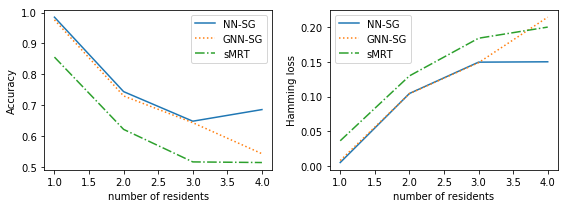

In [47]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

metrics = ['Accuracy', 'Hamming loss']

axes_dict = {
  'Accuracy': axes[0],
  'Hamming loss': axes[1]
}

method_labels = {
  'nnsg': 'NN-SG',
  'gnnsg': 'GNN-SG',
  'smrt': 'sMRT'
}

linestyles = ['-', ':', '-.']

plot_array = {}

for metric in metrics:
  ax = axes_dict[metric]
  for i, method in enumerate(methods):
    ax.plot(mc_results_nr[method]['nr_list'], mc_results_nr[method][metric], ls=linestyles[i], label=method_labels[method])
  ax.legend()
  ax.set_ylabel(metric)
  ax.set_xlabel('number of residents')

figure.tight_layout()

## Error of the Estimated Number of Active Residents

The second goal of the tracking algorithm is to estimate the number of active residents.

## Multi-Resident Tracking Accuracy (MRTA)

Prior research in multi-target tracking and multi-object tracking in other applications, such as radar and video surveillance, have established additional performance metrics, such as multi-object tracking accuracy (MOTA).
In stead of looking at the correct associations observed in the system, MOTA metrics counts the number of errors and calculate the ratio of the total number of tracking errors over the number of total associations in the ground truth.
During the course of multi-resident tracking, there are three kinds of errors may occur: target miss, false positive, and track ID mismatch.

Target misses occur when a sensor event is associated with an active resident in the smart home while the tracking algorithm fails to associate the event with any target identifier that corresponds to the resident in the ground truth.



In [2]:
import pickle
from smrt.metrics import mrt_metrics

In [4]:
# Compute MRTA with basic settings
mrta_performance = {}

for method in methods:
  mrta_scores = mrt_metrics.mrta(event_lists[method])
  mrta_performance[method] = mrta_scores
  mrta_performance[method]['mrta'] = 1 - (mrta_scores['misses'] + mrta_scores['fp'] + mrta_scores['mismatch']) / mrta_scores['total']

49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40592.0000 - misses: 7435.0000 - fp: 5230.0000 - mismatch: 3331.0000
mrta: 0.6885
49253/49253 [==============================] - 0s 7us/step - total: 51358.0000 - correct: 31256.0000 - misses: 7024.0000 - fp: 10334.0000 - mismatch: 13078.0000
mrta: 0.4074
49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 37108.0000 - misses: 9879.0000 - fp: 12602.0000 - mismatch: 4371.0000
mrta: 0.4772


In [5]:
mrta_performance

{'nnsg': {'total': 51358,
  'correct': 40592,
  'misses': 7435,
  'fp': 5230,
  'mismatch': 3331,
  'mrta': 0.688539273336189},
 'gnnsg': {'total': 51358,
  'correct': 31256,
  'misses': 7024,
  'fp': 10334,
  'mismatch': 13078,
  'mrta': 0.4073756766229214},
 'smrt': {'total': 51358,
  'correct': 37108,
  'misses': 9879,
  'fp': 12602,
  'mismatch': 4371,
  'mrta': 0.4771603255578488}}

In [6]:
for method in mrta_performance:
  scores = mrta_performance[method]
  print(method, ": ", scores['correct']/scores['total'])

nnsg :  0.7903734569103158
gnnsg :  0.6085906772070564
smrt :  0.7225359242961175


In [7]:
mrta_v_track_length = {
  'mrta': {method: [] for method in methods}, 
  'misses': {method: [] for method in methods},
  'false positives': {method: [] for method in methods},
  'mismatches': {method: [] for method in methods}
}

metrics = ['mrta', 'misses', 'false positives', 'mismatches']

for method in methods:
  for i in range(10):
    result = mrt_metrics.mrta(event_lists[method], min_length=i+1)
    scores = {
      'mrta': 1 - (result['fp'] + result['misses'] + result['mismatch']) / result['total'],
      'misses': result['misses'] / result['total'],
      'false positives': result['fp'] / result['total'],
      'mismatches': result['mismatch'] / result['total']
    }
    for metric in metrics:
      mrta_v_track_length[metric][method].append(scores[metric])

49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40583.0000 - misses: 7355.0000 - fp: 5250.0000 - mismatch: 3420.0000
mrta: 0.6880
49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40585.0000 - misses: 7378.0000 - fp: 5235.0000 - mismatch: 3395.0000
mrta: 0.6883
49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40592.0000 - misses: 7435.0000 - fp: 5230.0000 - mismatch: 3331.0000
mrta: 0.6885
49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40560.0000 - misses: 7544.0000 - fp: 5225.0000 - mismatch: 3254.0000
mrta: 0.6880
49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40511.0000 - misses: 7637.0000 - fp: 5218.0000 - mismatch: 3210.0000
mrta: 0.6872
49253/49253 [==============================] - 0s 6us/step - total: 51358.0000 - correct: 40476.0000 - misses: 7713.0000 - fp: 5214.0000 - m

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

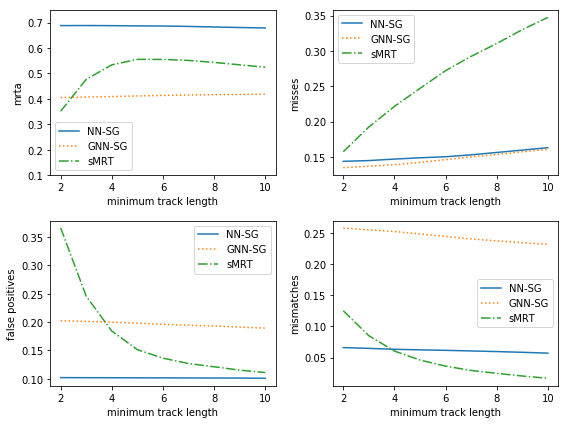

In [9]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

axes_dict = {
  'mrta': axes[0][0],
  'misses': axes[0][1],
  'false positives': axes[1][0],
  'mismatches': axes[1][1]
}

method_labels = {
  'nnsg': 'NN-SG',
  'gnnsg': 'GNN-SG',
  'smrt': 'sMRT'
}

linestyles = ['-', ':', '-.']

for metric in metrics:
  ax = axes_dict[metric]
  for i, method in enumerate(methods):
    ax.plot(range(2, 11), np.array(mrta_v_track_length[metric][method])[1:], ls=linestyles[i], label=method_labels[method])
  ax.legend()
  ax.set_ylabel(metric)
  ax.set_xlabel('minimum track length')

axes_dict['mrta'].set_ylim(0.1, 0.75)
figure.tight_layout()

In [31]:
figure.savefig('mrta_v_track_length.pdf')

## Performance versus maximum undetected length

## Performance versus number of residents

In [27]:
# Compute MRTA with basic settings
mrta_nr_performance = {}

for method in methods:
  mrta_nr_scores = mrt_metrics.mrta_by_nr(event_lists[method], min_length=5)
  mrta_nr_performance[method] = mrta_nr_scores
  for nr in mrta_nr_performance[method]:
    mrta_scores = mrta_nr_performance[method][nr]
    mrta_scores['mrta'] = 1 - (mrta_scores['misses'] + mrta_scores['fp'] + mrta_scores['mismatch']) / mrta_scores['total']

49253/49253 [==============================] - 0s 8us/step - total: 1.0000 - correct: 1.0000 - misses: 0.0000e+00 - fp: 0.0000e+00 - mismatch: 0.0000e+00


In [28]:
n_events = len(event_lists['nnsg'])
for i in range(n_events):
  assert(event_lists['nnsg'][i]['residents'] == event_lists['smrt'][i]['residents'])
  
mrta_nr_performance

{'nnsg': {1: {'num_events': 19986,
   'total': 19868,
   'correct': 17701,
   'misses': 170,
   'fp': 191,
   'mismatch': 1997,
   'mrta': 0.8813166901550231},
  2: {'num_events': 27508,
   'total': 29586,
   'correct': 21539,
   'misses': 6862,
   'fp': 4583,
   'mismatch': 1185,
   'mrta': 0.5731089028594605},
  3: {'num_events': 1654,
   'total': 1799,
   'correct': 1202,
   'misses': 572,
   'fp': 414,
   'mismatch': 25,
   'mrta': 0.43802112284602557},
  4: {'num_events': 105,
   'total': 105,
   'correct': 69,
   'misses': 33,
   'fp': 30,
   'mismatch': 3,
   'mrta': 0.37142857142857144}},
 'gnnsg': {1: {'num_events': 19986,
   'total': 19868,
   'correct': 12688,
   'misses': 280,
   'fp': 2331,
   'mismatch': 6900,
   'mrta': 0.5212905174149386},
  2: {'num_events': 27508,
   'total': 29586,
   'correct': 17576,
   'misses': 6437,
   'fp': 7210,
   'mismatch': 5573,
   'mrta': 0.350368417494761},
  3: {'num_events': 1654,
   'total': 1799,
   'correct': 999,
   'misses': 547,


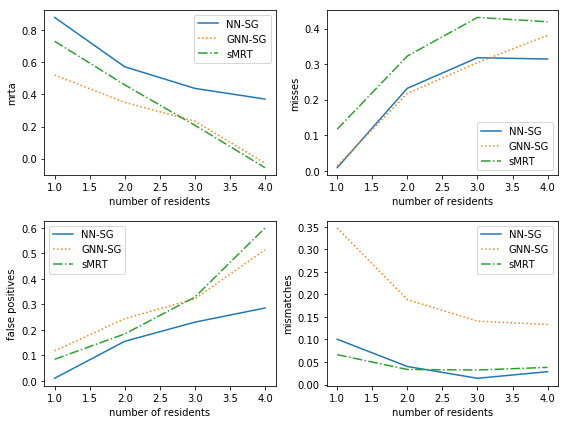

In [29]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

metrics = ['mrta', 'misses', 'false positives', 'mismatches']

axes_dict = {
  'mrta': axes[0][0],
  'misses': axes[0][1],
  'false positives': axes[1][0],
  'mismatches': axes[1][1]
}

method_labels = {
  'nnsg': 'NN-SG',
  'gnnsg': 'GNN-SG',
  'smrt': 'sMRT'
}

linestyles = ['-', ':', '-.']

plot_array = {}

for i, method in enumerate(methods):
  nr_list = list(mrta_nr_performance[method].keys())
  nr_list.sort()
  plot_array[method] = {
    'x': nr_list,
    'mrta': [mrta_nr_performance[method][nr]['mrta'] for nr in nr_list],
    'false positives': [mrta_nr_performance[method][nr]['fp'] / mrta_nr_performance[method][nr]['total'] for nr in nr_list],
    'misses': [mrta_nr_performance[method][nr]['misses'] / mrta_nr_performance[method][nr]['total'] for nr in nr_list],
    'mismatches': [mrta_nr_performance[method][nr]['mismatch'] / mrta_nr_performance[method][nr]['total'] for nr in nr_list],
  }

for metric in metrics:
  ax = axes_dict[metric]
  for i, method in enumerate(methods):
    ax.plot(plot_array[method]['x'], plot_array[method][metric], ls=linestyles[i], label=method_labels[method])
  ax.legend()
  ax.set_ylabel(metric)
  ax.set_xlabel('number of residents')

figure.tight_layout()

In [30]:
figure.savefig('mrta_vs_num_residents.pdf')